## Set Up Dependencies and Data


In [1]:
import random

import alifedata_phyloinformatics_convert as apc
from Bio import Phylo as BioPhylo
from hstrat import hstrat
from hsurf import hsurf
import joblib
import more_itertools as mit
import pandas as pd
from teeplot import teeplot as tp

from pylib._draw_biopython_tree import draw_biopython_tree
from pylib._make_hamming_distance_matrix import make_hamming_distance_matrix
from pylib._val_to_color import val_to_color


In [2]:
df = pd.read_csv("https://osf.io/7dve5/download")


## Reproducibility


In [3]:
%load_ext watermark
%watermark -iwbmuvg -iv


Last updated: 2024-03-04T04:10:41.844400+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.20.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.5.0-1015-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

Git hash: 645c53b301571fd214844714a549ef669c102d70

Git branch: HEAD

alifedata_phyloinformatics_convert: 0.16.2
pandas                            : 1.5.3
Bio                               : 1.83
hstrat                            : 1.11.1
more_itertools                    : 10.2.0
teeplot                           : 1.0.1
joblib                            : 1.3.2
hsurf                             : 0.3.0

Watermark: 2.4.3



In [4]:
df.head()


,bitfield
0,77064756713668357415073525191
1,77064737824238309593663130836
2,30240547418216718020720024161
3,68783544018723857427193644511
4,1851408510276755850611569268


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   bitfield  9 non-null      object
dtypes: object(1)
memory usage: 200.0+ bytes


In [6]:
df.describe()


,bitfield
count,9
unique,8
top,68783525124783816603834197597
freq,2


In [7]:
joblib.hash(df)


'e664c46ee9d4e0f0892ce69733348dfa'

## Data Prep


In [8]:
exclude_leading = 16

df["bitfield"] = df["bitfield"].apply(int)
df["bitfield value bitlengths"] = df["bitfield"].apply(int.bit_length)
df["bitfield wordlengths"] = (df["bitfield value bitlengths"] + 31) // 32
assert mit.one(df["bitfield wordlengths"].unique()) == 3
df["bitfield bitlengths"] = df["bitfield wordlengths"] * 32
df["surface bitlengths"] = df["bitfield bitlengths"] - exclude_leading
df["surface bytelengths"] = df["surface bitlengths"] // 8

df


,bitfield,bitfield value bitlengths,bitfield wordlengths,bitfield bitlengths,surface bitlengths,surface bytelengths
0,77064756713668357415073525191,96,3,96,80,10
1,77064737824238309593663130836,96,3,96,80,10
2,30240547418216718020720024161,95,3,96,80,10
3,68783544018723857427193644511,96,3,96,80,10
4,1851408510276755850611569268,91,3,96,80,10
5,68783534574145182538748371176,96,3,96,80,10
6,1851356573380009383893728895,91,3,96,80,10
7,68783525124783816603834197597,96,3,96,80,10
8,68783525124783816603834197597,96,3,96,80,10


In [9]:
bitfield_bitlength = int(mit.one(df["bitfield bitlengths"].unique()))
surface_mask = (  # mask off leading 16 bits
    1 << (bitfield_bitlength - exclude_leading)
) - 1
assert surface_mask.bit_count() == bitfield_bitlength - exclude_leading
df["bitfield surface"] = df["bitfield"].values & surface_mask

df


,bitfield,bitfield value bitlengths,bitfield wordlengths,bitfield bitlengths,surface bitlengths,surface bytelengths,bitfield surface
0,77064756713668357415073525191,96,3,96,80,10,571416514206044253629895
1,77064737824238309593663130836,96,3,96,80,10,552527084158222843235540
2,30240547418216718020720024161,95,3,96,80,10,476966376383844619737697
3,68783544018723857427193644511,96,3,96,80,10,500585929915903111054815
4,1851408510276755850611569268,91,3,96,80,10,543080446758584136413812
5,68783534574145182538748371176,96,3,96,80,10,491141351241014665781480
6,1851356573380009383893728895,91,3,96,80,10,491143550012117418573439
7,68783525124783816603834197597,96,3,96,80,10,481691989875079751607901
8,68783525124783816603834197597,96,3,96,80,10,481691989875079751607901


In [10]:
df["bitfield tag"] = df["bitfield"].values >> (
    bitfield_bitlength - exclude_leading
)

df


,bitfield,bitfield value bitlengths,bitfield wordlengths,bitfield bitlengths,surface bitlengths,surface bytelengths,bitfield surface,bitfield tag
0,77064756713668357415073525191,96,3,96,80,10,571416514206044253629895,63746
1,77064737824238309593663130836,96,3,96,80,10,552527084158222843235540,63746
2,30240547418216718020720024161,95,3,96,80,10,476966376383844619737697,25014
3,68783544018723857427193644511,96,3,96,80,10,500585929915903111054815,56896
4,1851408510276755850611569268,91,3,96,80,10,543080446758584136413812,1531
5,68783534574145182538748371176,96,3,96,80,10,491141351241014665781480,56896
6,1851356573380009383893728895,91,3,96,80,10,491143550012117418573439,1531
7,68783525124783816603834197597,96,3,96,80,10,481691989875079751607901,56896
8,68783525124783816603834197597,96,3,96,80,10,481691989875079751607901,56896


In [11]:
df["taxon name"] = df.index.astype(str) + "-" + df["bitfield tag"].apply(hex)

df


,bitfield,bitfield value bitlengths,bitfield wordlengths,bitfield bitlengths,surface bitlengths,surface bytelengths,bitfield surface,bitfield tag,taxon name
0,77064756713668357415073525191,96,3,96,80,10,571416514206044253629895,63746,0-0xf902
1,77064737824238309593663130836,96,3,96,80,10,552527084158222843235540,63746,1-0xf902
2,30240547418216718020720024161,95,3,96,80,10,476966376383844619737697,25014,2-0x61b6
3,68783544018723857427193644511,96,3,96,80,10,500585929915903111054815,56896,3-0xde40
4,1851408510276755850611569268,91,3,96,80,10,543080446758584136413812,1531,4-0x5fb
5,68783534574145182538748371176,96,3,96,80,10,491141351241014665781480,56896,5-0xde40
6,1851356573380009383893728895,91,3,96,80,10,491143550012117418573439,1531,6-0x5fb
7,68783525124783816603834197597,96,3,96,80,10,481691989875079751607901,56896,7-0xde40
8,68783525124783816603834197597,96,3,96,80,10,481691989875079751607901,56896,8-0xde40


In [12]:
df.dtypes


bitfield                     object
bitfield value bitlengths     int64
bitfield wordlengths          int64
bitfield bitlengths           int64
surface bitlengths            int64
surface bytelengths           int64
bitfield surface             object
bitfield tag                 object
taxon name                   object
dtype: object

## Deserialize Columns


In [13]:
surface_bytelength = int(mit.one(df["surface bytelengths"].unique()))
print(f"{surface_bytelength=}")
site_selection_algo = hsurf.tilted_sticky_algo
differentia_bitwidth = 1

hstrat_columns = [
    hsurf.col_from_surf_int(
        value=value,
        differentia_bit_width=differentia_bitwidth,
        site_selection_algo=site_selection_algo,
        differentiae_byte_bit_order="little",
        num_strata_deposited_byte_width=2,  # u16
        num_strata_deposited_byte_order="little",
        value_byte_width=surface_bytelength,
    )
    for value in df["bitfield surface"].values
]


surface_bytelength=10


In [14]:
for col in hstrat_columns:
    print(col.GetNumStrataDeposited())


121
117
101
106
115
104
104
102
102


## Reconstruct Tree


In [15]:
tree_df = hstrat.build_tree(
    hstrat_columns,
    hstrat.__version__,
    taxon_labels=df["taxon name"].values,
    force_common_ancestry=True,
)


In [16]:
tree_df["name"] = tree_df["taxon_label"]


## Ascii Reconstructed Tree


In [17]:
print(apc.RosettaTree(tree_df).as_dendropy.as_ascii_plot(plot_metric="length"))


          /------------------------------------------------- 6-0x5fb           
   /------+                                                                    
   |      \------------------------------------------------------- 4-0x5fb     
   |                                                                           
/--+                                                      /8-0xde40            
|  |                /-------------------------------------+                    
|  |              /-+                                     \7-0xde40            
|  |              | |                                                          
+  \--------------+ \--------------------------------------- 5-0xde40          
|                 |                                                            
|                 \------------------------------------------ 3-0xde40         
|                                                                              
+                                       

## Plotted Reconstructed Tree


In [18]:
biopy_tree = apc.RosettaTree(tree_df).as_biopython


In [19]:
biopy_tree.get_terminals()[0].name
biopy_tree.root


Clade(branch_length=0.0, id=0, name='Root', origin_time=0.0)

In [20]:
salt = "7"  # manually chosen for nice generated colors

# adapted from https://github.com/mmore500/hstrat-recomb-concept/blob/b71d36216f1d2990343b6435240d8c193a82690b/pylib/tree/color_biopython_tree.py
def color_biopython_tree(tree: BioPhylo.BaseTree) -> None:
    """Recursively color tree"""
    terminals = [x.name.split("-")[1] for x in tree.get_terminals()]
    if len(set(terminals)) != 1:
        tree.color = (220, 220, 220)
    else:
        tree.color = val_to_color(mit.one(set(terminals)) + salt)

    for clade in tree.clades:
        color_biopython_tree(clade)

color_biopython_tree(biopy_tree.root)


teeplots/genome=hsurftiltedsticky_tagged+viz=draw-biopython-tree+ext=.pdf


teeplots/genome=hsurftiltedsticky_tagged+viz=draw-biopython-tree+ext=.png


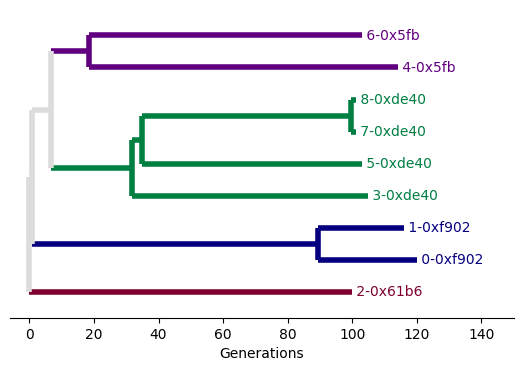

In [21]:
tp.tee(
    draw_biopython_tree,
    biopy_tree,
    teeplot_outattrs={
        "genome": "hsurftiltedsticky_tagged",
    },
)


## Random tree


In [22]:
dummy = [random.randint(0, 2**80) for _ in range(9)]
print(make_hamming_distance_matrix(dummy).upgma_tree().as_ascii_plot())


/---------------------------------------------------------------------------- 6
|                                                                              
|                                             /------------------------------ 5
+              /------------------------------+                                
|              |                              |              /--------------- 0
|              |                              \--------------+                 
|              |                                             \--------------- 7
\--------------+                                                               
               |                                             /--------------- 1
               |              /------------------------------+                 
               |              |                              \--------------- 8
               \--------------+                                                
                              |         